In [11]:
#Torch Modules
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import VOCDetection
from torchvision import ops
import torch.utils as tu
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence

#Other modules
import os, random
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import time
import io

#Image processing modules
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import Utils.utils as utils
from Utils.config_loader import ConfigLoader
from lib.Loaders.base_dataset import BaseDataset

In [2]:
#from lib.Model.AnchorGen import AnchorGenerator
#from lib.Model.backbones.vgg16 import VGG16_BACKBONE
#from lib.Model.rpn_utils.rpn import RegionProposalNetwork
#from lib.Model.rpn_utils.rpn_proposal_gen import RPNProposalGenerator
#from lib.Model.roi_utils.roi import ROINetwork
#from Model.one_stage_detector import OneStageDetector
from lib.Model.faster_rcnn_detector import FRCNNDetector

In [25]:
from Utils.logger_utils import TrainingLogger

In [14]:
config = ConfigLoader("cord_e10.yaml")

In [13]:
#"cuda:1" if torch.cuda.is_available() else 
device = torch.device("cuda:3")

In [5]:
#collate = lambda batch: list(zip(*batch))

In [6]:
model = FRCNNDetector(config)
model = model.to(device)

In [7]:
model.train()

FRCNNDetector(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [15]:
img_width, img_height, img_depth = config.get("IMG_WIDTH"), config.get("IMG_HEIGHT"), config.get("CHANNELS")
train_dataset = BaseDataset(config, pad=False)


In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset.getDataset(), batch_size=2, shuffle=True, pin_memory=True)

In [19]:
len(train_loader)

400

In [23]:
file_path = os.path.join(config.get('SAVE_PATH_CHECKPOINT'), "log.txt")
with open(file_path, 'a') as f:
    print(true)

NameError: name 'true' is not defined

In [9]:
for img_batch, targets_batch in train_loader:
    #img_data = [img.to(device) for img in img_batch]
    img_data = img_batch.to(device)
    targets_data = {k:v.to(device) for k,v in targets_batch.items()}
    #targets_data = [{k:v.to(device) for k,v in target.items()} for target in targets_batch]
    break

In [10]:
start_ = time.time()
rpn_loss, roi_loss, roi_out = model(img_data, targets_data)
print(time.time() - start_)

0.8747692108154297


In [11]:
losses = sum(loss for loss in rpn_loss.values()) + sum(loss for loss in roi_loss.values())

In [12]:
losses.backward()

In [13]:
model.eval()
start_ = time.time()
out = model.inference(img_data)
print(time.time() - start_)

0.30936384201049805


In [14]:
out

{'boxes': [tensor([], device='cuda:3', size=(0, 4))],
 'scores': [tensor([], device='cuda:3')],
 'labels': [tensor([], device='cuda:3', dtype=torch.int64)]}

In [15]:
!nvidia-smi

Mon Apr 17 02:07:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   47C    P2    56W / 250W |   9169MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 27%   

In [9]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

def getFasterRCNN(aspect_sizes, aspect_ratios, num_classes):
    #Defining backbone
    backbone = torchvision.models.vgg16(weights="DEFAULT").features
    backbone.out_channels = 512
    #Defining Anchor Generator
    anchorGenerator = AnchorGenerator(sizes=aspect_sizes, aspect_ratios=aspect_ratios)
    
    model = FasterRCNN(backbone, rpn_anchor_generator=anchorGenerator, num_classes=num_classes)
    
    return model

frcnn = getFasterRCNN(((8,16,32),),((0.5,1,2),),num_classes)
frcnn = frcnn.to(device)
optimizer = torch.optim.SGD(frcnn.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [11]:
import datetime
total_time_start = time.time()
losses_list = []
for epoch in range(20):
    frcnn.train()
    epoch_start = time.time()
    batch_no = 1
    temp_loss = 0
    for images, targets in train_loader:
        batch_start = time.time()
        images = [img.to(device) for img in images]
        targets = [{k:v.to(device) for k,v in target.items()} for target in targets]
        
        optimizer.zero_grad()
        
        with torch.autocast('cuda'):
            losses = frcnn(images, targets)
            losses = sum([loss for loss in losses.values()])
        
        losses.backward()
        optimizer.step()
        
        batch_duration = time.time() - batch_start
        temp_loss += float(losses)
        if batch_no % 100 == 0:
            print(f"{batch_no}--{str(datetime.timedelta(seconds = batch_duration))}--{losses}")
        batch_no += 1
    losses_list.append(temp_loss / batch_no)
    epoch_duration = time.time() - epoch_start
    print(f"{epoch}--{str(datetime.timedelta(seconds = epoch_duration))}")
duration = time.time() - total_time_start
print(f"Model Trained : {str(datetime.timedelta(seconds = duration))}")

100--0:00:00.128227--0.7245230674743652
200--0:00:00.125484--1.4648404121398926
300--0:00:00.127109--0.7057572603225708
400--0:00:00.128061--0.5477327108383179
0--0:02:01.389332
100--0:00:00.131635--0.5850701928138733
200--0:00:00.121176--0.7241842746734619
300--0:00:00.123953--0.5417253375053406
400--0:00:00.121178--0.47737568616867065
1--0:02:00.817500
100--0:00:00.124514--0.6100170016288757
200--0:00:00.125596--0.5350244641304016
300--0:00:00.125119--0.8258647918701172
400--0:00:00.125738--0.9002768993377686
2--0:02:01.768825
100--0:00:00.125170--1.1618598699569702
200--0:00:00.123958--1.0996699333190918
300--0:00:00.129525--0.7491157054901123
400--0:00:00.129722--0.7647570967674255
3--0:02:01.395213
100--0:00:00.125087--0.5012997388839722
200--0:00:00.120182--0.9389590620994568
300--0:00:00.119869--0.6308745741844177
400--0:00:00.121391--0.9366858601570129
4--0:02:01.461788
100--0:00:00.125325--0.5609008073806763
200--0:00:00.130497--0.30196863412857056
300--0:00:00.122663--0.68557

In [12]:
#new_device = torch.device("cuda:3")
frcnn = frcnn.to(device)
frcnn.eval()
img_data = [img.to(device) for img in img_data]
targets_data = [{k:v.to(device) for k,v in target.items()} for target in targets_data]
out = frcnn(img_data, targets_data)

In [27]:
targets_data

[{'boxes': tensor([[ 28.,  89.,  36.,  96.],
          [ 40.,  89.,  64.,  96.],
          [ 68.,  89., 104.,  97.],
          [107.,  89., 132.,  97.],
          [196.,  90., 233.,  97.],
          [ 27.,  97.,  35., 104.],
          [ 39.,  96.,  81., 105.],
          [ 85.,  97., 115., 105.],
          [197.,  98., 234., 106.],
          [ 26., 106.,  34., 112.],
          [ 38., 106.,  92., 114.],
          [ 96., 106., 137., 114.],
          [142., 106., 166., 115.],
          [199., 106., 235., 115.],
          [ 36., 123.,  97., 139.],
          [165., 124., 239., 140.],
          [ 34., 138.,  85., 154.],
          [167., 139., 242., 156.]], device='cuda:1'),
  'labels': tensor([ 1,  5,  5,  5,  7,  1,  5,  5,  7,  1,  5,  5,  5,  7, 27, 27, 22, 22],
         device='cuda:1'),
  'image_id': tensor([517], device='cuda:1'),
  'area': tensor([  56.,  168.,  288.,  200.,  259.,   56.,  378.,  240.,  296.,   48.,
           432.,  328.,  216.,  324.,  976., 1184.,  816., 1275.],
   

In [28]:
out

[{'boxes': tensor([[ 33.2497, 121.8519,  98.8744, 139.2588],
          [164.2118, 122.9538, 240.4425, 141.1970],
          [ 67.0497,  88.8689, 106.3997,  95.5997],
          [ 37.7981,  88.9936,  64.9921,  96.1896],
          [196.3337,  89.3958, 232.6559,  97.0319],
          [106.6042,  89.1208, 131.7303,  97.0142],
          [196.1112,  95.5744, 233.3631, 104.2476],
          [196.6914,  92.5392, 233.1507,  99.4446],
          [142.3268, 106.3262, 165.9322, 113.7293],
          [ 38.8055, 106.2145,  92.8912, 115.2401],
          [ 27.7267,  89.7103,  34.4830,  94.3516],
          [198.2878, 107.1686, 234.9725, 115.0130],
          [ 33.8265, 138.4206,  86.3110, 155.0213],
          [ 24.3743, 105.0557,  36.8215, 113.0774],
          [ 37.4243,  96.4516,  81.1519, 102.9189],
          [ 96.7608, 106.3073, 137.4120, 112.8044],
          [ 34.0888,  97.9400,  83.2868, 105.7800],
          [ 29.1133,  90.6961,  31.9546,  94.5117],
          [ 39.6566,  93.0009,  63.3158,  98.7654],
   

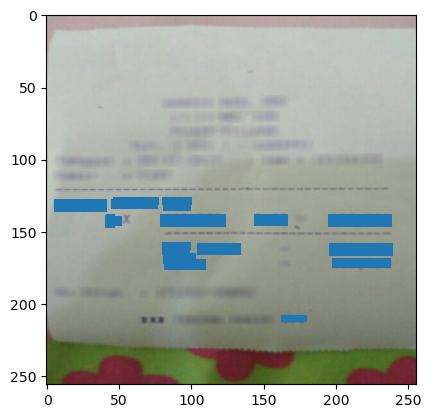

In [16]:
fig,ax = plt.subplots()
ax.imshow(img_data[1].permute(1,2,0).cpu().numpy())

boxes = out[1]['boxes'].cpu().detach().numpy()
scores = out[1]['scores'].cpu().detach().numpy()
for index,box in enumerate(boxes):
    x1,y1,x3,y3 = box
    score = scores[index]
    if score > 0.4:
        rect = patches.Rectangle((x1,y1),(x3-x1),(y3-y1))
        ax.add_patch(rect)

plt.show()

In [68]:
pred_boxes = out[0]['boxes']
target_boxes = targets_data[0]['boxes']

In [73]:
ious = ops.box_iou(pred_boxes, target_boxes)

In [76]:
torch.max(ious, dim=1)

torch.return_types.max(
values=tensor([0.5395, 0.1185, 0.4360, 0.4351, 0.3970, 0.2389, 0.0494, 0.2262, 0.5490,
        0.4017, 0.0587, 0.1534, 0.5910, 0.1966, 0.0472, 0.1081, 0.3839, 0.0172,
        0.4172, 0.0176, 0.0412, 0.0459, 0.1108, 0.0379, 0.5170, 0.0000, 0.1769,
        0.1663, 0.6677, 0.0000, 0.6483, 0.5136, 0.5754, 0.0493, 0.1430, 0.4600,
        0.6153, 0.0673, 0.6335, 0.6942, 0.3281, 0.3767, 0.3957, 0.1853, 0.0214,
        0.3044, 0.3303, 0.0385, 0.2475, 0.5214, 0.2242, 0.6422, 0.1664, 0.0177,
        0.1032, 0.0000, 0.6149, 0.4770, 0.0000, 0.0733, 0.3838, 0.0436, 0.1749,
        0.4783, 0.0490, 0.1737, 0.4383, 0.1288, 0.4145, 0.2073, 0.0432, 0.0252,
        0.3345, 0.5129, 0.1046, 0.3261, 0.0595, 0.0041, 0.6408, 0.0159, 0.0257,
        0.5103, 0.1650, 0.0637, 0.0977, 0.2016, 0.4783, 0.3597, 0.0391, 0.0357,
        0.0152, 0.0000, 0.2872, 0.3523, 0.4747, 0.0204, 0.0354, 0.0612, 0.0222,
        0.2109], device='cuda:3', grad_fn=<MaxBackward0>),
indices=tensor([ 4,  4,  4,  1

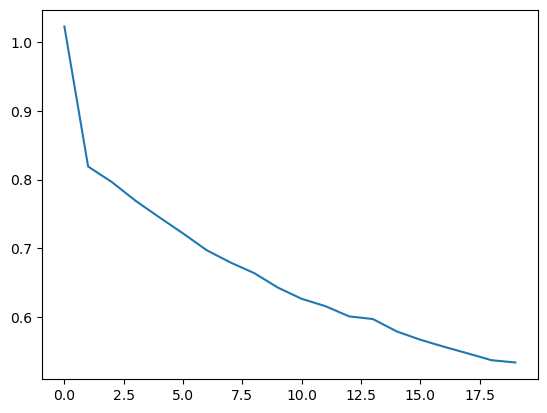

In [18]:
plt.plot(losses_list)
plt.show()

In [81]:
class MAPEvaluator:
    def __init__(self, iou_threshs: list, num_classes: int, ignore_pad=True, pad_value=-1, device=None):
        
        for iou_thresh in iou_threshs:
            assert isinstance(iou_thresh, float), f"Expected floating point value for iou threshold. Got type {type(iou_thresh)}"
        
        self.iou_threshs = iou_threshs
        self.num_classes = num_classes
        self.ignore_pad = ignore_pad
        self.pad_value = pad_value
        
        self.device = device if device != None else torch.device('cpu')
    
    def prepare(self, pred_dicts, gt_dicts):
        batch_size = len(gt_dicts)
        #Each element of preds is a list of {Img Id, Label, Score, [x1,y1,x3,y3]]
        preds = []
        #Each element of gts is a list of [Img Id, Label, [x1,y1,x3,y3]] 
        gts = []
        
        for pred_dict, gt_dict in zip(pred_dicts, gt_dicts):
            img_id = gt_dict['image_id'].detach().cpu().numpy()[0]
            
            for idx, pred_box in enumerate(pred_dict['boxes']):
                label = int(pred_dict['labels'][idx].detach().cpu().numpy())
                score = float(pred_dict['scores'][idx].detach().cpu().numpy())
                box = pred_box.detach().cpu().numpy()
                
                preds.append([img_id, label, score, box])
            
            for idx, gt in enumerate(gt_dict['boxes']):
                if self.ignore_pad:
                    if sum(gt == self.pad_value) == 4:
                        continue
                
                label = int(gt_dict['labels'][idx].cpu().numpy())
                box = gt.cpu().numpy()
                
                gts.append([img_id, label, box])
                
        return preds, gts
            
        
    
    def evaluate(self, pred_dict, gt_dict):
        assert isinstance(pred_dict, (list, tuple)), f"Expected type list(Dicts) or tuple(Dicts) for predictions got {type(pred_dict)}"
        assert isinstance(gt_dict, (list, tuple)), f"Expected type list(Dicts) or tuple(Dicts) for ground truths got {type(gt_dict)}"
        pred_values, gt_values = self.prepare(pred_dict, gt_dict)
        
        
        
        
        
        
        return pred_values, gt_values

In [82]:
evaluator = MAPEvaluator([0.5], 30)

In [83]:
a, b = evaluator.evaluate(out, targets_data)

In [85]:
b

[[517, 1, 28.0, 89.0, 36.0, 96.0],
 [517, 5, 40.0, 89.0, 64.0, 96.0],
 [517, 5, 68.0, 89.0, 104.0, 97.0],
 [517, 5, 107.0, 89.0, 132.0, 97.0],
 [517, 7, 196.0, 90.0, 233.0, 97.0],
 [517, 1, 27.0, 97.0, 35.0, 104.0],
 [517, 5, 39.0, 96.0, 81.0, 105.0],
 [517, 5, 85.0, 97.0, 115.0, 105.0],
 [517, 7, 197.0, 98.0, 234.0, 106.0],
 [517, 1, 26.0, 106.0, 34.0, 112.0],
 [517, 5, 38.0, 106.0, 92.0, 114.0],
 [517, 5, 96.0, 106.0, 137.0, 114.0],
 [517, 5, 142.0, 106.0, 166.0, 115.0],
 [517, 7, 199.0, 106.0, 235.0, 115.0],
 [517, 27, 36.0, 123.0, 97.0, 139.0],
 [517, 27, 165.0, 124.0, 239.0, 140.0],
 [517, 22, 34.0, 138.0, 85.0, 154.0],
 [517, 22, 167.0, 139.0, 242.0, 156.0],
 [749, 5, 4.0, 127.0, 42.0, 135.0],
 [749, 5, 45.0, 127.0, 77.0, 135.0],
 [749, 5, 80.0, 127.0, 100.0, 135.0],
 [749, 1, 40.0, 138.0, 47.0, 145.0],
 [749, 1, 51.0, 138.0, 59.0, 145.0],
 [749, 12, 80.0, 137.0, 122.0, 146.0],
 [749, 7, 195.0, 137.0, 239.0, 146.0],
 [749, 2, 143.0, 137.0, 168.0, 145.0],
 [749, 27, 80.0, 158.0, 9

In [13]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [14]:
def evaluate(model, test_loader, ious=None, device=torch.device('cpu'), custom=False):
    
    if not(custom):
        model.eval()
        model = model.to(device)
    else:
        device = model.getDevice()
    
    if ious == None:
        map_evaluator = MeanAveragePrecision()
    else:
        map_evaluator = MeanAveragePrecision(iou_thresholds=ious)
    
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k:v.to(device) for k,v in target.items()} for target in targets]
        
        if custom:
            out = model.inference(images)
        else:
            out = model(images)
        
        map_evaluator.update(out, targets)
    
    computed = map_evaluator.compute()
    
    return computed
        